In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.8.0


In [2]:
# !pip install git+https://github.com/tensorflow/docs

In [2]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## 힉스 데이터세트

In [4]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [5]:
FEATURES = 28

In [6]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")
"""
이 코드는 tf.data.experimental.CsvDataset 클래스를 사용하여 CSV 데이터를 로드합니다.
이 클래스는 파일 이름, 필드를 구문 분석하는 데 사용할 데이터 유형의 목록, 그리고 압축 형식을 매개변수로 받습니다.
gz : CSV 파일의 경로 혹은 파일 명입니다. 이 파일은 GZIP으로 압축되어 있습니다.
[float(),]*(FEATURES+1) : 데이터 유형의 목록을 제공합니다.
여기서 모든 특징은 부동 소수점 숫자임을 알려주는 float()로 선언되어 있습니다.
FEATURES+1는 레이블을 포함한 특성의 총 수입니다.
compression_type="GZIP" : 압축 형식을 지정합니다. 이 경우 GZIP 형식입니다.
"""

In [7]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

"""
label = row[0]: 이 코드는 첫 번째 열이 레이블이라고 가정하고 레이블을 추출합니다.
features = tf.stack(row[1:],1): 나머지 열을 특성으로 사용하며, tf.stack을 사용하여 이들을 Tensor로 변환합니다.
                                1은 이 텐서들을 쌓을 차원을 나타냅니다.
"""

In [9]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()
"""
batch(): 데이터셋을 지정된 배치 크기로 분할합니다.
        여기서는 한 번에 10000개의 요소를 가지는 배치를 생성합니다.
        이는 모델 학습 시 GPU 등의 하드웨어 가속을 최대한 활용하기 위해 주로 사용됩니다.
"""

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


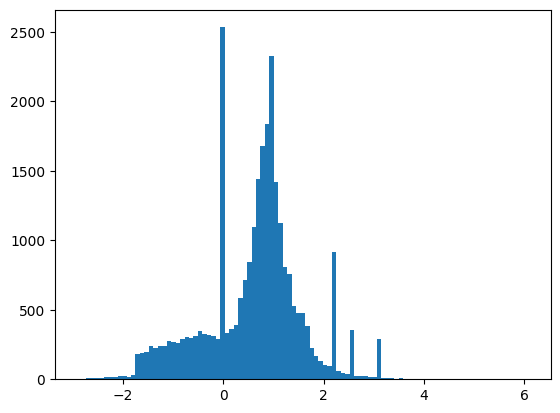

In [10]:
for features,label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [11]:
N_VALIDATION = int(1e3)
"""
검증(validation) 데이터셋의 크기를 설정합니다. 여기서는 1000개의 데이터 샘플을 검증 데이터셋으로 사용합니다.
검증 데이터셋은 모델의 성능을 평가하는 데 사용되며, 훈련 과정에서 모델이 과적합되지 않도록 하는 역할을 합니다.
"""
N_TRAIN = int(1e4)
#훈련(train) 데이터셋의 크기를 설정합니다. 여기서는 10000개의 데이터
BUFFER_SIZE = int(1e4)
"""
버퍼 크기를 설정합니다.
이는 tf.data.Dataset의 shuffle 메서드에서 사용되며, 데이터셋을 섞는데 사용되는 버퍼의 크기를 의미합니다.
즉, 데이터셋의 요소를 무작위로 섞으려면 버퍼의 크기가 충분히 커야 합니다.
"""
BATCH_SIZE = 500
#배치 크기를 설정합니다. 배치 크기는 한 번에 처리되는 데이터 샘플의 개수를 의미합니다.
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [12]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [13]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [14]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## 과대적합

In [15]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)
"""
InverseTimeDecay는 학습률이 시간에 따라 감소하는 스케줄링 방법입니다.
초기 학습률, 감소 단계 수, 감소율, 그리고 staircase 옵션을 파라미터로 받습니다.
이 스케줄러는 주어진 감소율에 따라 학습률을 감소시키는데, 감소율은 각 스텝마다 적용되며 스텝 수에 반비례합니다.
staircase 옵션이 True로 설정된 경우 학습률은 각 decay_steps에서 갑자기 감소하지만,
                False인 경우 학습률은 각 스텝마다 부드럽게 감소합니다.
"""

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

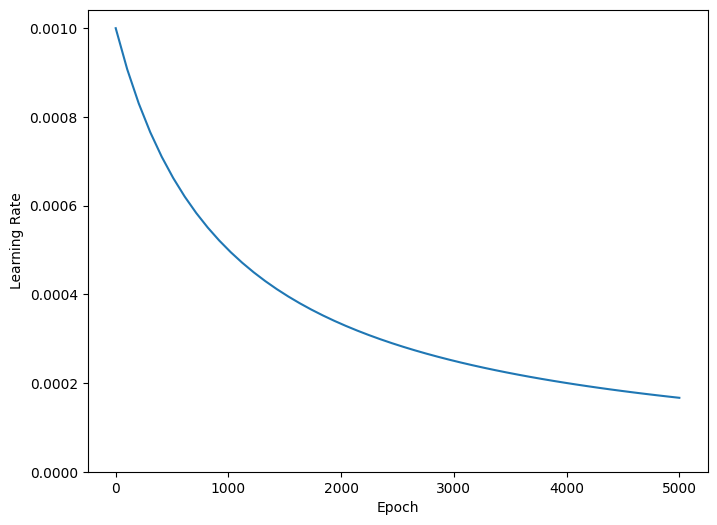

In [16]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [17]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        # 검증 데이터셋에 대한 손실
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200), 
        tf.keras.callbacks.TensorBoard(logdir/name), #  훈련의 진행 상황을 시각화하는 콜백입니다.
    ]

In [18]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                    tf.keras.losses.BinaryCrossentropy(
                        from_logits=True, name='binary_crossentropy'), #훈련 데이터셋에 대한 손실
                    'accuracy'])

    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0)
    return history

## 미소모델

In [19]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])
"""
Exponential Linear Unit(지수 선형 유닛)의 약자입니다. 이 활성화 함수는 ReLU(Rectified Linear Unit)와 유사하지만,
음수 입력에 대해서는 약간 다른 동작을 합니다. ReLU는 음수 입력에 대해 0을 출력하지만,
ELU는 음수 입력에 대해 약간의 음수 값을 출력합니다.
이로 인해 ELU는 ReLU가 가진 '죽은 뉴런' 문제를 완화하는데 도움이 됩니다.
'죽은 뉴런' 문제는 ReLU를 사용하는 뉴런이 학습 과정에서 더 이상 업데이트되지 않게 되는 현상을 말합니다.
"""

In [20]:
size_histories = {}

In [21]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5023,  binary_crossentropy:0.7595,  loss:0.7595,  val_accuracy:0.5010,  val_binary_crossentropy:0.7376,  val_loss:0.7376,  
....................................................................................................
Epoch: 100, accuracy:0.6047,  binary_crossentropy:0.6213,  loss:0.6213,  val_accuracy:0.5780,  val_binary_crossentropy:0.6235,  val_loss:0.6235,  
............................................................

(0.5, 0.7)

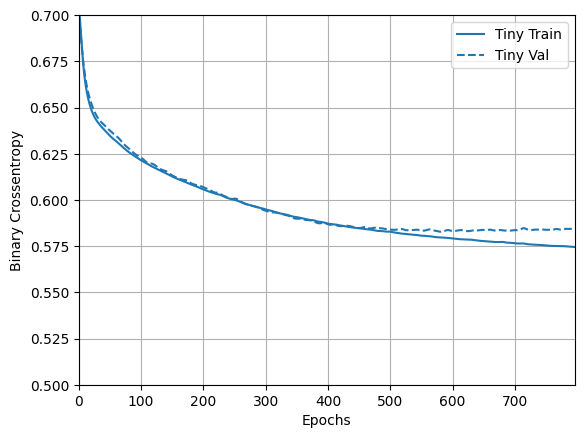

In [22]:
# 확인
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

## 작은모델

In [23]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [24]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4788,  binary_crossentropy:0.7296,  loss:0.7296,  val_accuracy:0.4840,  val_binary_crossentropy:0.6989,  val_loss:0.6989,  
....................................................................................................
Epoch: 100, accuracy:0.6098,  binary_crossentropy:0.6196,  loss:0.6196,  

### 작은모델 만들기

In [25]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4923,  binary_crossentropy:0.7017,  loss:0.7017,  val_accuracy:0.4720,  val_binary_crossentropy:0.6814,  val_loss:0.6814,  
....................................

## 큰모델 만들기

In [27]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [28]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               14848     
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5085,  binary_crossentropy

## 훈련, 검증 손실 그래프 시각화

Text(0.5, 0, 'Epochs [Log Scale]')

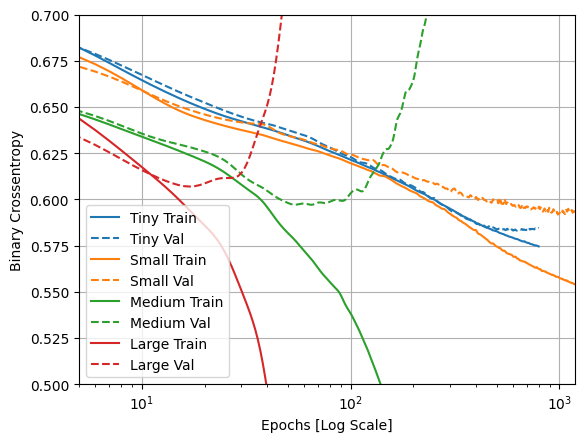

In [29]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [30]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

Launching TensorBoard...

In [31]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

In [32]:
tensorboard dev upload --logdir  {logdir}/sizes

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 8208.

In [33]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/user/AppData/Local/Temp/tmpk09u8ebg/tensorboard_logs/regularizers/Tiny')

In [34]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [35]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                kernel_regularizer=regularizers.l2(0.001),
                input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               14848     
                                                                 


 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5032,  binary_crossentropy:0.7665,  loss:2.2657,  val_accuracy:0.5370,  val_binary_crossentropy:0.6820,  val_loss:2.0886,  
....................................................................................................
Epoch: 100, accuracy:0.6369,  binary_crossentropy:0.6078,  loss:0.6295,  val_accuracy:0

(0.5, 0.7)

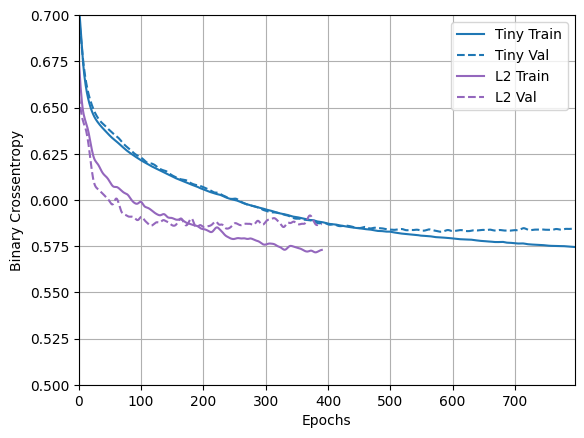

In [36]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [37]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

In [38]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 512)              

(0.5, 0.7)

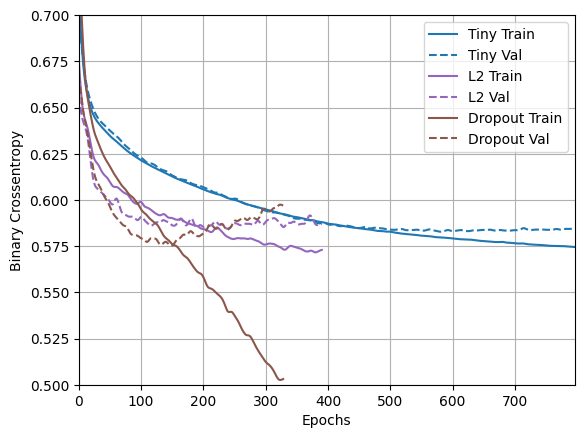

In [39]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [40]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               14848     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 512)              

 dense_28 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5050,  binary_crossentropy:0.7905,  loss:0.9490,  val_accuracy:0.5030,  val_binary_crossentropy:0.6732,  val_loss:0.8311,  
....................................................................................................
Epoch: 100, accuracy:0.6514,  binary_crossentropy:0.6048,  loss:0.6344,  val_accuracy:0.6770,  val_binary_crossentropy:0.5823,  val_loss:0.6117,  
....................................................................................................
Epoch: 200, accuracy:0.6651,  binary_crossentropy:0.5912,  loss:0.6159,  val_accuracy:0.6620,  val_binary_crossentropy:0.5761,  val_loss:0.6008,  
........................................................................................

(0.5, 0.7)

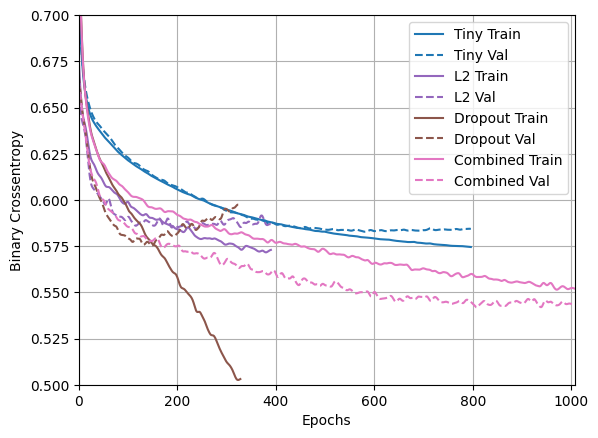

In [41]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [42]:
%tensorboard --logdir {logdir}/regularizers

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 13488.

In [43]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")

In [44]:
tensorboard dev upload --logdir  {logdir}/regularizers

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 22924.

## 결론
 - 더 많은 훈련 데이터를 얻음
 - 네트워크 용량을 줄임
 - 가중치 정규화를 추가함
 - 드롭아웃을 추가함

 ### 중요접근방식(그 자체로 도움이 될 수 있지만 이를 결합하여 더 큰 효과를 거둘 수 있는 경우가 종종 있다)
  - 데이터 증강
  - 배치 정규화(tf.keras.layers.BatchNormalization)